In [44]:
import lightkurve as lk
import pandas as pd

def download_all_spoc_sectors(target_id, output_csv='tess_spoc_data.csv'):
    # Step 1: Search for all SPOC light curves
    search_result = lk.search_lightcurve(f'TIC {target_id}', author='SPOC', mission='TESS')

    if len(search_result) == 0:
        print(f"No SPOC data found for TIC {target_id}.")
        return

    print(f"Found {len(search_result)} SPOC light curve files for TIC {target_id}.")

    # Step 2: Download each sector separately and keep sector info
    all_dfs = []

    for i, result in enumerate(search_result):
        lc = result.download()
        sector_number = lc.sector if hasattr(lc, 'sector') else None
        print(f"Downloaded sector {sector_number}")
        # Convert time from BTJD to BJD by adding 2457000
        bjd_time = lc.time.value + 2457000

        # Create DataFrame for this sector
        df = pd.DataFrame({
            '#time':  bjd_time,
            'flux_initial': lc.pdcsap_flux.value,
            'flux_err_initial': lc.pdcsap_flux_err.value
          
        })

        all_dfs.append(df)

    # Step 3: Combine all sectors and sort by time
    full_df = pd.concat(all_dfs, ignore_index=True).dropna().sort_values(by='#time')
    median_flux = full_df['flux_initial'].median()
    median_flux_err = full_df['flux_err_initial'].median()
    print(f"Median flux: {median_flux}, Median flux error: {median_flux_err}")  
    full_df['flux'] = full_df['flux_initial'] / median_flux
    full_df['flux_err'] = full_df['flux_err_initial'] /  median_flux
    full_df = full_df.drop(columns=['flux_initial', 'flux_err_initial'])

    # Sort by time and save
    full_df = full_df.sort_values(by='#time')
    print(full_df.head())

    # Step 4: Save to CSV
    output_file = output_csv.replace('.csv', f'_TIC{target_id}_raw.csv')
    full_df.to_csv(output_file, index=False)
    print(f"\n✅ Saved SPOC light curve from all sectors to: {output_file}")

# Example usage
download_all_spoc_sectors(461591646)


Found 8 SPOC light curve files for TIC 461591646.
Downloaded sector 52
Downloaded sector 53
Downloaded sector 59
Downloaded sector 60
Downloaded sector 73
Downloaded sector 78
Downloaded sector 79
Downloaded sector 86
Median flux: 6414.3671875, Median flux error: 11.181695938110352
          #time      flux  flux_err
0  2.459719e+06  0.995422  0.001732
1  2.459719e+06  0.994242  0.001732
2  2.459719e+06  0.995038  0.001733
3  2.459719e+06  0.996503  0.001733
4  2.459719e+06  0.995542  0.001732

✅ Saved SPOC light curve from all sectors to: tess_spoc_data_TIC461591646_raw.csv


In [27]:
import pandas as pd
import lightkurve as lk
import numpy as np

# Load your light curve
df = pd.read_csv('TOI2155_initial.csv')

# Create a LightCurve object
lc = lk.LightCurve(time=df['#time'], flux=df['flux'])

# Detrend using Savitzky–Golay filter
flattened_lc = lc.flatten(window_length=4321, polyorder=2)

# Create DataFrame from detrended data
df_detrended = pd.DataFrame({
    '#time': flattened_lc.time.value,
    'flux': flattened_lc.flux.value,
    'flux_err': df['flux_err']  # Keep original error
})

# Drop rows with NaNs
df_detrended = df_detrended.dropna()

# Remove outliers using sigma clipping
flux_mean = np.mean(df_detrended['flux'])
flux_std = np.std(df_detrended['flux'])

# Define threshold (5-sigma here)
sigma_threshold = 5
mask = np.abs(df_detrended['flux'] - flux_mean) < sigma_threshold * flux_std
df_detrended = df_detrended[mask]

# Sort by time
df_detrended = df_detrended.sort_values(by='#time')

# Save to CSV
df_detrended.to_csv('TOI2155_detrended.csv', index=False)


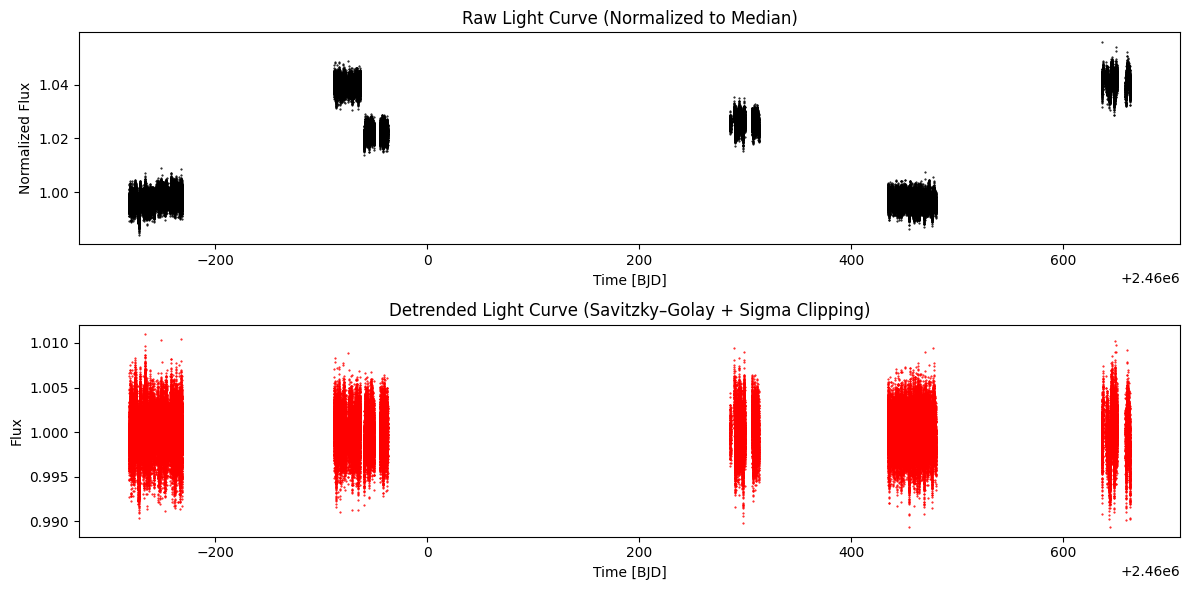

In [ ]:
import pandas as pd
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

# Load the raw data
df = pd.read_csv('TOI2155_initial.csv')

# Normalize raw flux to median = 1
df['flux_normalized'] = df['flux'] / np.nanmedian(df['flux'])

# Create LightCurve object
lc = lk.LightCurve(time=df['#time'], flux=df['flux'])

# Detrend using Savitzky–Golay filter
flattened_lc = lc.flatten(window_length=4321, polyorder=2)

# Create DataFrame from detrended data
df_detrended = pd.DataFrame({
    '#time': flattened_lc.time.value,
    'flux': flattened_lc.flux.value,
    'flux_err': df['flux_err']
}).dropna()

# Remove outliers using sigma clipping
flux_mean = np.mean(df_detrended['flux'])
flux_std = np.std(df_detrended['flux'])
sigma_threshold = 5
mask = np.abs(df_detrended['flux'] - flux_mean) < sigma_threshold * flux_std
df_detrended = df_detrended[mask]

# Sort by time
df_detrended = df_detrended.sort_values(by='#time')

# Save to CSV
df_detrended.to_csv('TOI2155_detrended.csv', index=False)

# Plottingx
plt.figure(figsize=(12, 6))

# Normalized raw light curve
plt.subplot(2, 1, 1)
plt.plot(df['#time'], df['flux_normalized'], 'k.', markersize=1)
plt.title('Raw Light Curve (Normalized to Median)')
plt.xlabel('Time [BJD]')
plt.ylabel('Normalized Flux')

# Detrended light curve
plt.subplot(2, 1, 2)
plt.plot(df_detrended['#time'], df_detrended['flux'], 'r.', markersize=1)
plt.title('Detrended Light Curve (Savitzky–Golay + Sigma Clipping)')
plt.xlabel('Time [BJD]')
plt.ylabel('Flux')

plt.tight_layout()
plt.show()


/var/folders/yh/hv33dfk17snff4td_nxq68wh0000gp/T/ipykernel_4809/2529574857.py:13: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc_pdcsap = lc.PDCSAP_FLUX


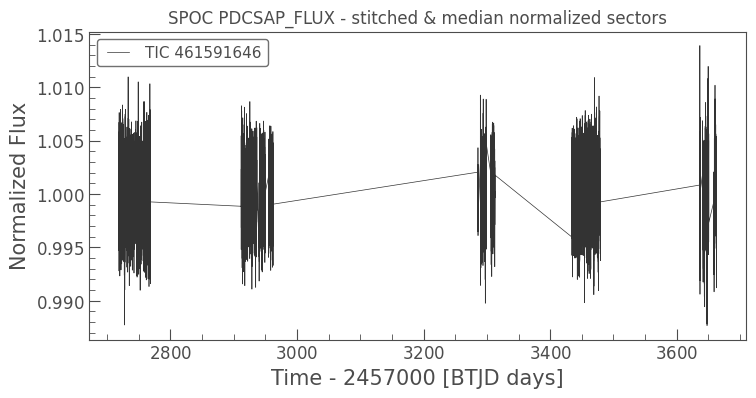

In [50]:
import lightkurve as lk
import matplotlib.pyplot as plt

# Search for all TESS SPOC light curves for your target
search_result = lk.search_lightcurve("TOI 2155", mission="TESS", author="SPOC")

# Download all sectors (returns a LightCurveCollection)
lc_collection = search_result.download_all()

cleaned_lcs = []
for lc in lc_collection:
    # Use PDCSAP_FLUX, remove NaNs in time and flux
    lc_pdcsap = lc.PDCSAP_FLUX
    if lc_pdcsap is not None:
        lc_clean = lc_pdcsap.remove_nans()
        # Normalize by median flux
        lc_norm = lc_clean.normalize()
        cleaned_lcs.append(lc_norm)

# Create a new LightCurveCollection from cleaned light curves
lc_clean_collection = lk.LightCurveCollection(cleaned_lcs)

# Stitch all normalized sectors together
lc_stitched = lc_clean_collection.stitch()

# Plot stitched light curve
lc_stitched.plot()
plt.title("SPOC PDCSAP_FLUX - stitched & median normalized sectors")
plt.show()


/var/folders/yh/hv33dfk17snff4td_nxq68wh0000gp/T/ipykernel_4809/2360837040.py:14: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc_pdcsap = lc.PDCSAP_FLUX


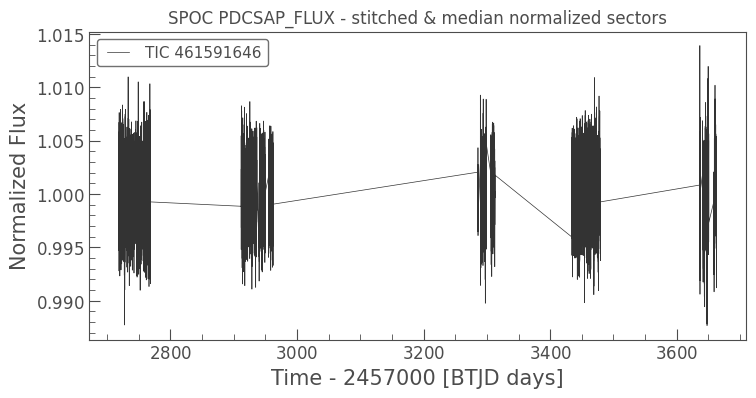

In [51]:
import lightkurve as lk
import matplotlib.pyplot as plt
import pandas as pd

# Search for all TESS SPOC light curves for your target
search_result = lk.search_lightcurve("TOI 2155", mission="TESS", author="SPOC")

# Download all sectors (returns a LightCurveCollection)
lc_collection = search_result.download_all()

cleaned_lcs = []
for lc in lc_collection:
    # Use PDCSAP_FLUX, remove NaNs in time and flux
    lc_pdcsap = lc.PDCSAP_FLUX
    if lc_pdcsap is not None:
        lc_clean = lc_pdcsap.remove_nans()
        # Normalize by median flux
        lc_norm = lc_clean.normalize()
        cleaned_lcs.append(lc_norm)

# Create a new LightCurveCollection from cleaned light curves
lc_clean_collection = lk.LightCurveCollection(cleaned_lcs)

# Stitch all normalized sectors together
lc_stitched = lc_clean_collection.stitch()

# Plot stitched light curve
lc_stitched.plot()
plt.title("SPOC PDCSAP_FLUX - stitched & median normalized sectors")
plt.show()

# Prepare DataFrame to save as CSV
df = pd.DataFrame({
    '#time': lc_stitched.time.value,
    'pdcsap_flux': lc_stitched.flux.value,
    'pdcsap_flux_err': lc_stitched.flux_err.value if lc_stitched.flux_err is not None else [None]*len(lc_stitched.flux)
})

# Save to CSV
df.to_csv('TOI2155_spoc_stitched_normalized.csv', index=False)


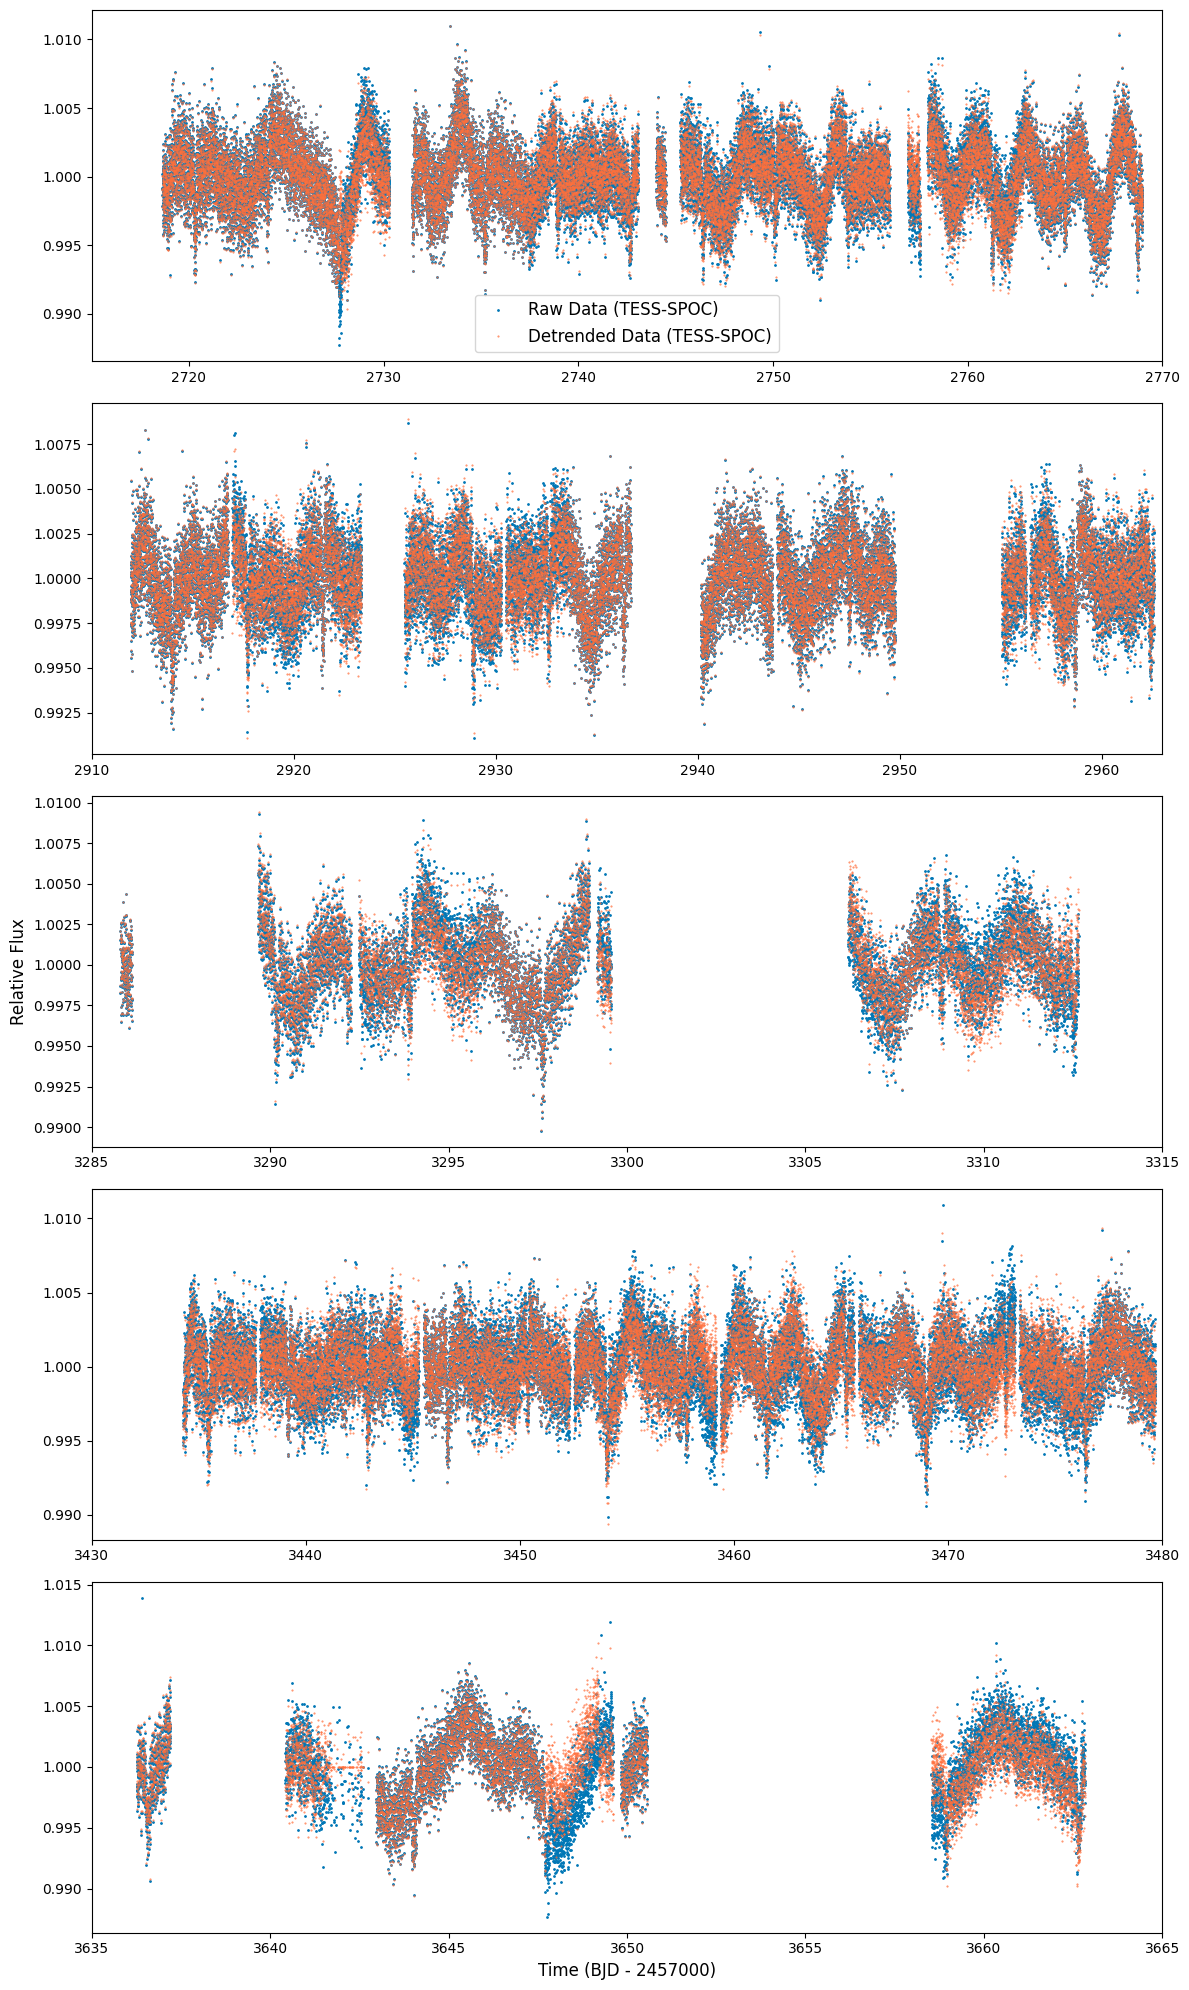

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# Load raw stitched normalized data
raw_df = pd.read_csv('TOI2155_spoc_stitched_normalized.csv')

# Load detrended flux data
detrended_df = pd.read_csv('TESS.csv')
detrended_df['#time'] = detrended_df['#time'] - 2457000  # Adjust time as you did

# Define the time ranges (sectors) you want to plot
time_ranges = [
    (2715, 2770),
    (2910, 2963),
    (3285, 3315),
    (3430, 3480),
    (3635, 3665)
]

# Colors for plotting
raw_color = '#0077b6'        # strong cyan-blue
detrended_color = '#ff6f3c'  # muted orange

# Create subplots, one for each time range
fig, axes = plt.subplots(len(time_ranges), 1, figsize=(12, 4 * len(time_ranges)), sharex=False)

for ax, (t_start, t_end) in zip(axes, time_ranges):
    # Filter raw data for current time range
    raw_mask = (raw_df['#time'] >= t_start) & (raw_df['#time'] <= t_end)
    raw_slice = raw_df[raw_mask]

    # Filter detrended data for current time range
    detrended_mask = (detrended_df['#time'] >= t_start) & (detrended_df['#time'] <= t_end)
    detrended_slice = detrended_df[detrended_mask]

    # Plot raw data (cyan-blue dots)
    ax.plot(raw_slice['#time'], raw_slice['pdcsap_flux'], 'o', color=raw_color, markersize=1, alpha=1, label='Raw Data (TESS-SPOC)')

    # Plot detrended data (muted orange dots)
    ax.plot(detrended_slice['#time'], detrended_slice['flux'], 'o', color=detrended_color, markersize=0.5, alpha=0.85, label='Detrended Data (TESS-SPOC)')

    ax.set_xlim(t_start, t_end)
    
    
    # ax.set_title(f'Time range: {t_start} - {t_end}', fontsize=14)
    # ax.grid(True, linestyle='--', alpha=0.3)

axes[-1].set_xlabel('Time (BJD - 2457000)', fontsize=12)
axes[2].set_ylabel('Relative Flux', fontsize=12)
axes[0].legend(loc='lower center', fontsize=12)
plt.tight_layout()
plt.savefig("allsec_detrended_plot.png", dpi=400)
plt.show()


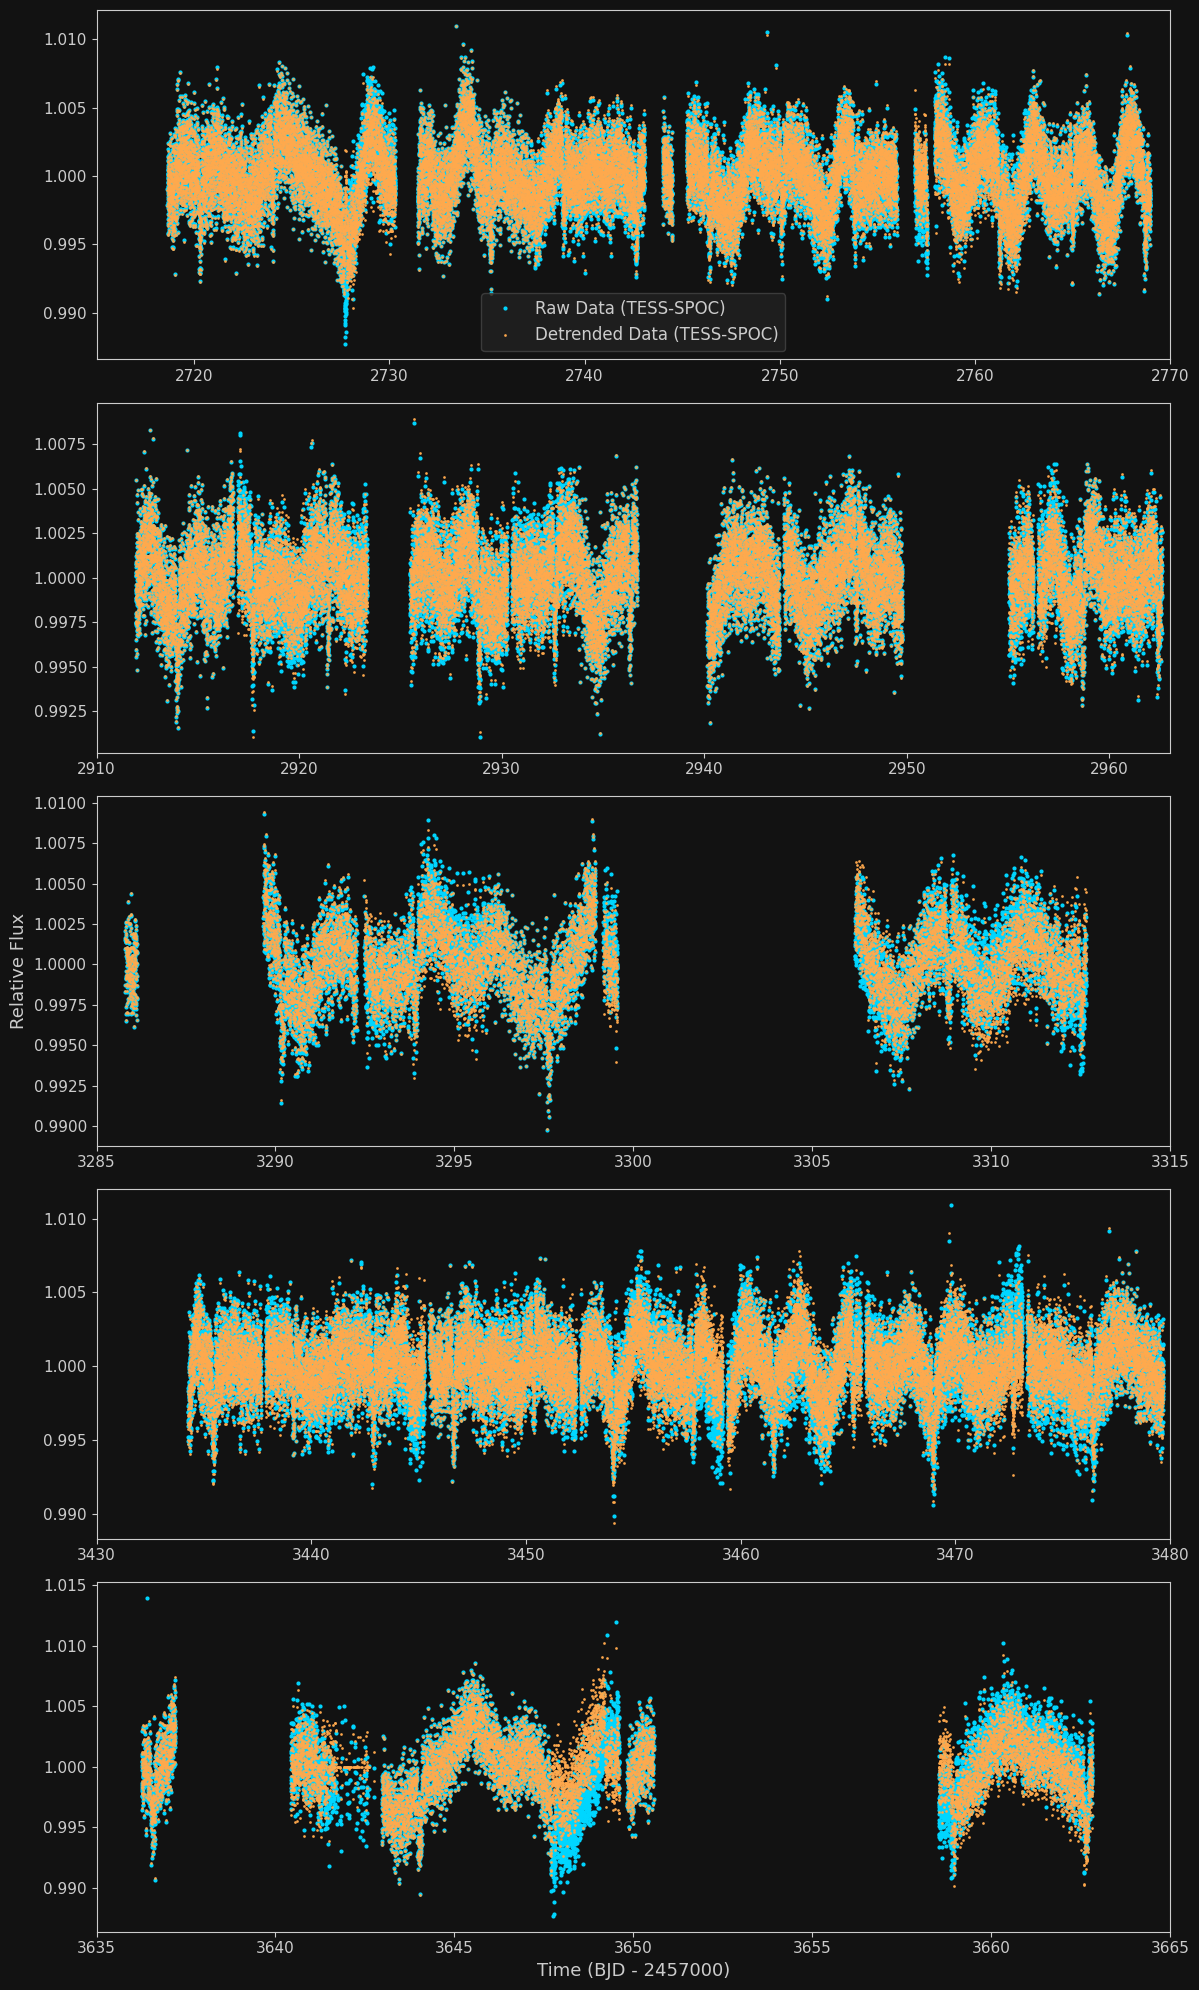

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# Load raw stitched normalized data
raw_df = pd.read_csv('TOI2155_spoc_stitched_normalized.csv')

# Load detrended flux data
detrended_df = pd.read_csv('TESS.csv')
detrended_df['#time'] = detrended_df['#time'] - 2457000  # Adjust time as you did

# Define the time ranges (sectors) you want to plot
time_ranges = [
    (2715, 2770),
    (2910, 2963),
    (3285, 3315),
    (3430, 3480),
    (3635, 3665)
]

# Colors for plotting (bright colors for dark bg)
raw_color = '#00d6ff'        # bright cyan
detrended_color = '#ffa94d'  # bright orange

# Dark background style
plt.style.use('dark_background')

# Create subplots, one for each time range
fig, axes = plt.subplots(len(time_ranges), 1, figsize=(12, 4 * len(time_ranges)), sharex=False)
fig.patch.set_facecolor('#121212')  # very dark background

for ax, (t_start, t_end) in zip(axes, time_ranges):
    # Set axis background color
    ax.set_facecolor('#121212')
    
    # Filter raw data for current time range
    raw_mask = (raw_df['#time'] >= t_start) & (raw_df['#time'] <= t_end)
    raw_slice = raw_df[raw_mask]

    # Filter detrended data for current time range
    detrended_mask = (detrended_df['#time'] >= t_start) & (detrended_df['#time'] <= t_end)
    detrended_slice = detrended_df[detrended_mask]

    # Plot raw data (bright cyan dots)
    ax.plot(raw_slice['#time'], raw_slice['pdcsap_flux'], 'o', color=raw_color, markersize=2, alpha=1, label='Raw Data (TESS-SPOC)')

    # Plot detrended data (bright orange dots)
    ax.plot(detrended_slice['#time'], detrended_slice['flux'], 'o', color=detrended_color, markersize=1, alpha=0.9, label='Detrended Data (TESS-SPOC)')

    ax.set_xlim(t_start, t_end)
    
    # Grid lines with subtle color
    # ax.grid(True, linestyle='--', linewidth=0.5, color='#444444', alpha=0.7)
    # 
    # Set axis spine and tick colors to light gray
    for spine in ax.spines.values():
        spine.set_color('#cccccc')
    ax.tick_params(colors='#cccccc', labelsize=11)

# Labels with light gray color
axes[-1].set_xlabel('Time (BJD - 2457000)', fontsize=13, color='#cccccc')
axes[2].set_ylabel('Relative Flux', fontsize=13, color='#cccccc')

# Legend on top subplot with custom colors and frame
axes[0].legend(loc='lower center', fontsize=12, frameon=True, facecolor='#222222', edgecolor='#444444', labelcolor='#cccccc')

plt.tight_layout()
plt.savefig("allsec_detrended_dark_bg.png", dpi=400)
plt.show()


Linear regression slope: 1.974e-09
R²: 0.00000
Rolling std (mean): 0.00177
ADF Statistic: -14.304
p-value (ADF): 0.000
Critical Values (ADF):
  1%: -3.430
  5%: -2.862
  10%: -2.567


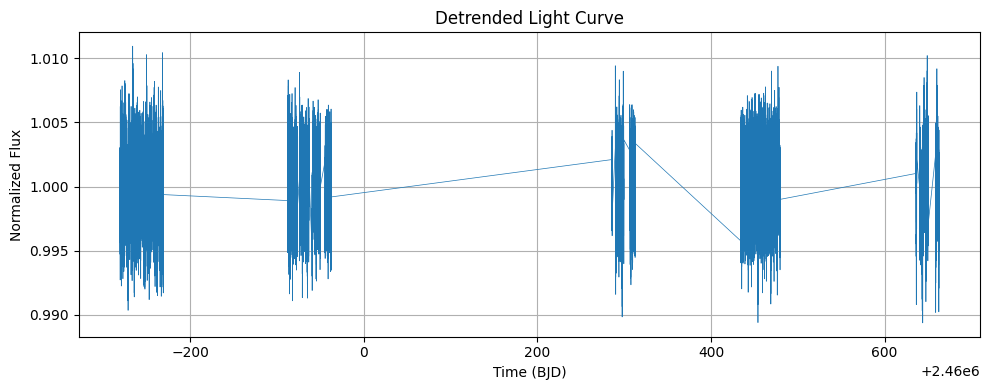

In [29]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Load your detrended data
df = pd.read_csv('TOI2155_detrended.csv')

time = df['#time']
flux = df['flux']

# 1. Linear trend check
slope, intercept, r_value, p_value, std_err = linregress(time, flux)
print(f"Linear regression slope: {slope:.3e}")
print(f"R²: {r_value**2:.5f}")

# 2. Rolling std check
rolling_std = flux.rolling(window=100).std()
print(f"Rolling std (mean): {np.nanmean(rolling_std):.5f}")

# 3. Stationarity test (ADF)
adf_result = adfuller(flux)
print(f"ADF Statistic: {adf_result[0]:.3f}")
print(f"p-value (ADF): {adf_result[1]:.3f}")
print("Critical Values (ADF):")
for key, val in adf_result[4].items():
    print(f"  {key}: {val:.3f}")

# 4. Optional: visualize
plt.figure(figsize=(10,4))
plt.plot(time, flux, lw=0.5)
plt.title('Detrended Light Curve')
plt.xlabel('Time (BJD)')
plt.ylabel('Normalized Flux')
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
search = lk.search_lightcurve('TIC 461591646', mission='TESS')
print(search.table.colnames)
print(search)


['intentType', 'obs_collection', 'provenance_name', 'instrument_name', 'project', 'filters', 'wavelength_region', 'target_name', 'target_classification', 'obs_id', 's_ra', 's_dec', 'dataproduct_type', 'proposal_pi', 'calib_level', 't_min', 't_max', 't_exptime', 'em_min', 'em_max', 'obs_title', 't_obs_release', 'proposal_id', 'proposal_type', 'sequence_number', 's_region', 'jpegURL', 'dataURL', 'dataRights', 'mtFlag', 'srcDen', 'obsid', 'objID', 'exptime', 'distance', 'obsID', 'obs_collection_products', 'dataproduct_type_products', 'description', 'type', 'dataURI', 'productType', 'productGroupDescription', 'productSubGroupDescription', 'productDocumentationURL', 'project_products', 'prvversion', 'proposal_id_products', 'productFilename', 'size', 'parent_obsid', 'dataRights_products', 'calib_level_products', 'filters_products', 'author', 'mission', '#', 'year', 'sort_order']
SearchResult containing 32 data products.

 #     mission     year   author  exptime target_name distance
        

In [ ]:
import lightkurve as lk
import pandas as pd

def download_spoc_sector52(target_id=461591646, sector=60):
    search = lk.search_lightcurve(f'TIC {target_id}', author="SPOC", mission="TESS")
    
    # Filter using the mission column which includes "TESS Sector XX"
    sector_str = f"TESS Sector {sector}"
    sector_results = search[search.table['mission'] == sector_str]

    if len(sector_results) == 0:
        print(f"❌ No SPOC light curve found for TIC {target_id} in Sector {sector}.")
        return

    print(f"✅ Found {len(sector_results)} SPOC result(s) for Sector {sector}. Downloading...")

    all_dfs = []
    for res in sector_results:
        lc = res.download()
        time_bjd = lc.time.value + 2457000
        flux = lc.flux.value.astype(float)      
        flux_err = lc.flux_err.value.astype(float)      

        

        df = pd.DataFrame({
            '#time': time_bjd,
            'flux_initial': flux,
            'flux_err_initial': flux_err
        })
        all_dfs.append(df)

    # Combine and normalize
    full_df = pd.concat(all_dfs).dropna().sort_values(by='#time')
    median_flux = full_df['flux_initial'].median()
    full_df['flux'] = full_df['flux_initial'] / median_flux
    full_df['flux_err'] = full_df['flux_err_initial'] / median_flux
    full_df = full_df.drop(columns=['flux_initial', 'flux_err_initial'])

    output_csv = f'TIC{target_id}_sector{sector}_SPOC.csv'
    full_df.to_csv(output_csv, index=False)
    print(f"✅ Light curve saved to: {output_csv}")

# Run the function
download_spoc_sector52()


✅ Found 1 SPOC result(s) for Sector 60. Downloading...
✅ Light curve saved to: TIC461591646_sector60_SPOC.csv


In [102]:
import lightkurve as lk
import pandas as pd

def download_and_detrend_spoc_sector(target_id, sector, window_length=4321, polyorder=2):
    # Search all SPOC light curves for the target
    search = lk.search_lightcurve(f'TIC {target_id}', author="SPOC", mission="TESS")

    # Filter only the desired sector
    sector_str = f"TESS Sector {sector}"
    sector_results = search[search.table['mission'] == sector_str]

    if len(sector_results) == 0:
        print(f"❌ No SPOC light curve found for TIC {target_id} in Sector {sector}.")
        return

    print(f"✅ Found {len(sector_results)} SPOC result(s) for Sector {sector}. Downloading and detrending...")

    all_dfs = []

    for res in sector_results:
        lc_raw = res.download()

        # Convert SAP/PDCSAP flux to LightCurve
        lc_pdcsap = lc_raw.normalize() if lc_raw.flux is not None else None
        if lc_pdcsap is None:
            print("⚠️ No PDCSAP_FLUX available.")
            continue

        # Detrend using flatten
        flattened_lc = lc_pdcsap.flatten(window_length=window_length, polyorder=polyorder)

        # Convert time to full BJD
        time_bjd = flattened_lc.time.value + 2457000

        df = pd.DataFrame({
            '#time': time_bjd,
            'flux': flattened_lc.flux.value,
            'flux_err': lc_pdcsap.flux_err.value  # Use original error
        })
        all_dfs.append(df)

    if not all_dfs:
        print("❌ No usable light curve data found.")
        return

    # Combine and clean
    full_df = pd.concat(all_dfs).dropna().sort_values(by='#time')

    output_csv = f'TIC{target_id}_sector{sector}_SPOC_detrended.csv'
    full_df.to_csv(output_csv, index=False)
    print(f"✅ Detrended light curve saved to: {output_csv}")

# Example usage
download_and_detrend_spoc_sector(target_id=461591646, sector=53)


✅ Found 1 SPOC result(s) for Sector 53. Downloading and detrending...
✅ Detrended light curve saved to: TIC461591646_sector53_SPOC_detrended.csv


In [103]:
import pandas as pd

# Load the two sector files
df_52 = pd.read_csv("TIC461591646_sector52_SPOC_detrended.csv")
df_53 = pd.read_csv("TIC461591646_sector53_SPOC_detrended.csv")

# Concatenate and sort by '#time'
combined_df = pd.concat([df_52, df_53])
combined_df = combined_df.sort_values(by="#time")

# Save to a new CSV file
combined_df.to_csv("TIC461591646_sector52_53_SPOC_merged_detrended.csv", index=False)

print("✅ Merged and sorted light curve saved to: TIC461591646_sector59_60_SPOC_merged.csv")





✅ Merged and sorted light curve saved to: TIC461591646_sector59_60_SPOC_merged.csv


[[2.45971863e+06 9.98994609e-01 1.73884180e-03]
 [2.45971863e+06 9.97810479e-01 1.73834510e-03]
 [2.45971864e+06 9.98609654e-01 1.73893350e-03]
 ...
 [2.45976897e+06 9.98734279e-01 1.63307060e-03]
 [2.45976897e+06 9.98921934e-01 1.63375100e-03]
 [2.45976898e+06 9.99373369e-01 1.63257520e-03]]


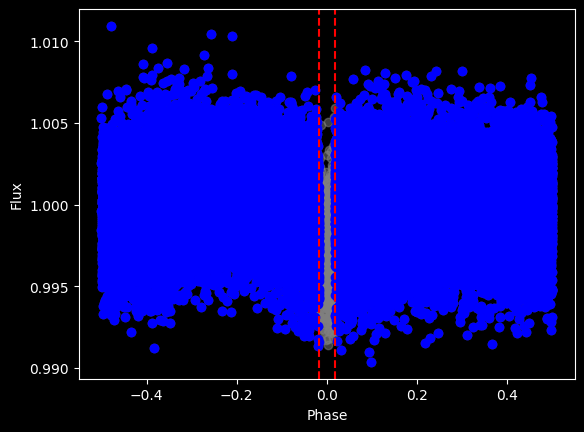

In [104]:
import numpy as np
import matplotlib.pyplot as plt


# Example data
data=np.loadtxt("TIC461591646_sector52_53_SPOC_merged_detrended.csv",skiprows=1,delimiter=',')

print(data)
time =data[ :,0] 
flux = data[ :,1] 
flux_err= data[ :,2]

#plt.scatter(time, flux, color="gray", alpha=0.5, label="All Data")
#plt.xlim(2459715, 2459723)


P=3.7246957








# Transit parameters
t0 = 2459485.6499 # Mid-transit time
T_T_days = 3.078/24 # Transit duration

phase = ((time - t0) / P) % 1
phase[phase > 0.5] -= 1  # Shift phase to range [-0.5, 0.5]

mask_width = (T_T_days / (2 * P))
out_of_transit_mask = (np.abs(phase) >mask_width)

# out_of_transit_mask = (np.abs(phase) > (T_T_days / (2 * P)))
# Extract out-of-transit data
time_out = time[out_of_transit_mask]
flux_out = flux[out_of_transit_mask]
flux_err_out = flux_err[out_of_transit_mask]
np.savetxt("out_of_transit_data_sec52_53.csv", 
           np.column_stack([time_out, flux_out, flux_err_out]), 
           delimiter=",", 
           header="time,flux,flux_err")
import matplotlib.pyplot as plt

plt.scatter(phase, flux, color="gray", alpha=0.5, label="All Data")
plt.scatter(phase[out_of_transit_mask], flux[out_of_transit_mask], color="blue", label="Out-of-Transit")
plt.axvline(-T_T_days / (2 * P), color='red', linestyle='--', label='Transit Edges')
plt.axvline(T_T_days / (2 * P), color='red', linestyle='--')
plt.xlabel("Phase")
plt.ylabel("Flux")
plt.show()
# plt.axvline(-half_transit_phase, color='orange', linestyle='--', label='Exclusion Edges')
# plt.axvline(half_transit_phase, color='orange', linestyle='--')
# 
# plt.legend()
# plt.xlim(-0.2, 0.2)



[[2.45971863e+06 9.98994609e-01 1.73884180e-03]
 [2.45971863e+06 9.97810479e-01 1.73834510e-03]
 [2.45971864e+06 9.98609654e-01 1.73893350e-03]
 ...
 [2.45976897e+06 9.98734279e-01 1.63307060e-03]
 [2.45976897e+06 9.98921934e-01 1.63375100e-03]
 [2.45976898e+06 9.99373369e-01 1.63257520e-03]]


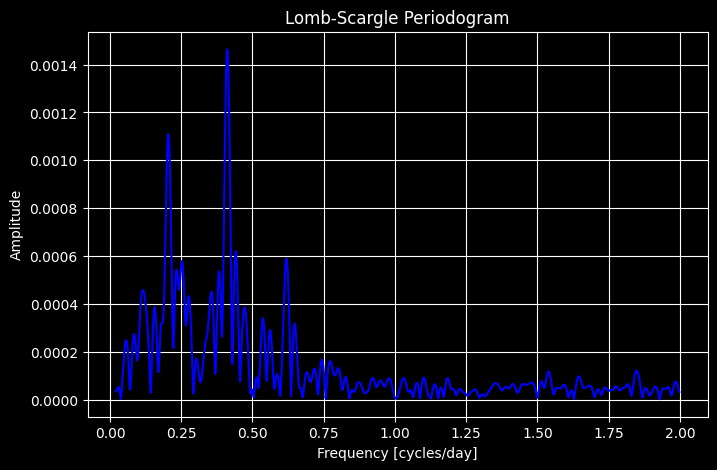

Best frequency: 0.411178 cycles/day
Corresponding period: 2.432039 days


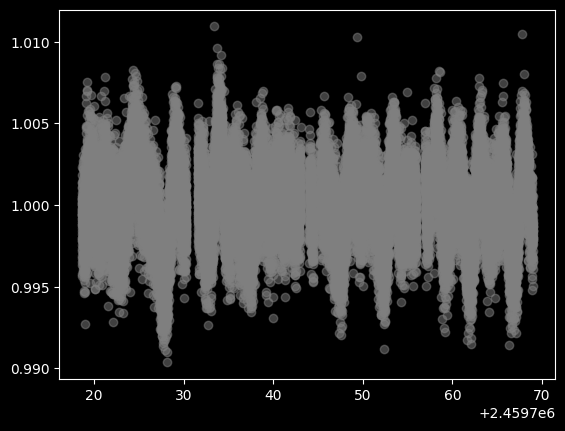

In [105]:
import numpy as np
import matplotlib.pyplot as plt
data=np.loadtxt("out_of_transit_data_sec52_53.csv",skiprows=1,delimiter=',')

print(data)
time =data[ :,0] 
flux = data[ :,1] 
flux_err= data[ :,2]

from astropy.timeseries import LombScargle
def calc_lomb_scargle(t,y):
    oversample = 10
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)
    fmin = df
    fmax = 2.0 # highest frequency (in c/d)
  
    freq = np.arange(fmin, fmax, df / oversample)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")
    fct = np.sqrt(4./len(t))
    amp = np.sqrt(sc) * fct
    return freq, amp 
freq, amp = calc_lomb_scargle(time, flux)
calc_lomb_scargle(time, flux)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(freq, amp, color='blue')

plt.xlabel("Frequency [cycles/day]")
plt.ylabel("Amplitude")
plt.title("Lomb-Scargle Periodogram")
plt.grid(True)
plt.show()
plt.scatter(time, flux, color='gray', alpha=0.5, label="Out-of-Transit Data")
# plt.xlim(2459715, 2459723)
# Compute the periodogram
freq, amp = calc_lomb_scargle(time, flux)

# Find the frequency with the highest amplitude
best_freq = freq[np.argmax(amp)]
best_period = 1.0 / best_freq

print(f"Best frequency: {best_freq:.6f} cycles/day")
print(f"Corresponding period: {best_period:.6f} days")


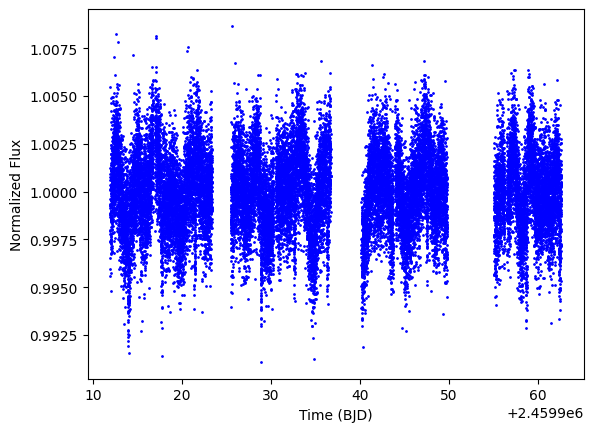

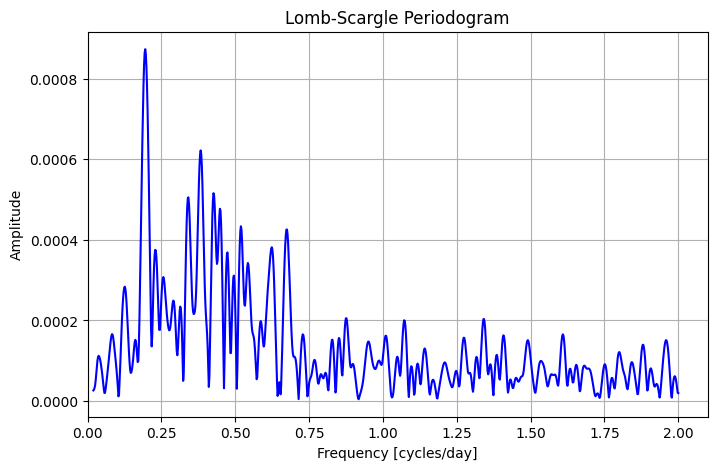

In [33]:
import pandas as pd
data1=pd.read_csv("TIC461591646_sector59_60_SPOC_merged.csv")
time = data1['#time'].values
flux = data1['flux'].values
plt.scatter(time, flux, color='blue', label="All Data", s=1)
plt.xlabel("Time (BJD)")
plt.ylabel("Normalized Flux")
# plt.xlim(2459720, 2459723+60)

from astropy.timeseries import LombScargle
def calc_lomb_scargle(t,y):
    oversample = 10
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)
    fmin = df
    fmax = 2.0 # highest frequency (in c/d)
  
    freq = np.arange(fmin, fmax, df / oversample)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")
    fct = np.sqrt(4./len(t))
    amp = np.sqrt(sc) * fct
    return freq, amp 
freq, amp = calc_lomb_scargle(time, flux)
calc_lomb_scargle(time, flux)


plt.figure(figsize=(8, 5))
plt.plot(freq, amp, color='blue')
plt.xlim(left=0)
plt.xlabel("Frequency [cycles/day]")
plt.ylabel("Amplitude")
plt.title("Lomb-Scargle Periodogram")
plt.grid(True)
plt.show()


In [4]:
#circulaziation timescale calculation
import numpy as np

# Constants
G = 6.67430e-11  # gravitational constant, m^3 kg^-1 s^-2
M_sun = 1.98847e30  # solar mass in kg
M_jup = 1.89813e27  # Jupiter mass in kg
R_sun = 6.957e8     # solar radius in meters
R_jup = 7.1492e7    # Jupiter radius in meters
sec_per_year =  3.15576e7 
sec_per_gyr = sec_per_year * 1e9

# Input parameters
M_star = 1.33 * M_sun   # mass of star in kg
R_star = 1.705 * R_sun      # radius of star in meters (assumed here, update if you have better data)
M_b = 77 * M_jup          # mass of brown dwarf in kg
R_b = 0.82 * R_jup        # radius of brown dwarf in meters
a = 0.0519 * 1.496e11     # semi-major axis in meters (1 AU = 1.496e11 m)
Q_star = 1e7            # tidal quality factor for star (assumed typical)
Q_b = 1e5                 # tidal quality factor for brown dwarf 

# Calculate a^(-13/2)
a_factor = a ** (-6.5)

# Calculate inverse circularization timescale due to star
tau_circ_star_inv = (171/16) * np.sqrt(G / M_star) * (((R_star**5) * M_b )/ Q_star) * a_factor

# Calculate inverse circularization timescale due to brown dwarf
tau_circ_b_inv = (63/4) * (np.sqrt(G * M_star**3) * (R_b**5)) / (Q_b * M_b) * a_factor

# Total inverse circularization timescale
tau_e_inv = tau_circ_star_inv+ tau_circ_b_inv

# Circularization timescale in seconds and converted to Gyr
tau_e_sec =  1/tau_e_inv
tau_e_gyr = tau_e_sec / sec_per_gyr

print(f"tau_circ_star_inv = {tau_circ_star_inv:.3e} s^-1")
print(f"tau_circ_b_inv = {tau_circ_b_inv:.3e} s^-1")
print(f"tau_e = {tau_e_sec:.3e} s, which is {tau_e_gyr:.3f} Gyr")


print(f"Circularization timescale tau_e = {tau_e_sec:.3e} seconds")
print(f"Circularization timescale tau_e = {tau_e_gyr:.3f} Gyr")


tau_circ_star_inv = 9.546e-17 s^-1
tau_circ_b_inv = 1.358e-18 s^-1
tau_e = 1.033e+16 s, which is 0.327 Gyr
Circularization timescale tau_e = 1.033e+16 seconds
Circularization timescale tau_e = 0.327 Gyr


In [4]:
import numpy as np
import pandas as pd

# Constants
G = 6.67430e-8        # Gravitational constant in cgs
M_jup = 1.898e30       # Jupiter mass in grams
R_jup = 7.1492e9       # Jupiter radius in cm
L_sun = 3.828e33       # Solar luminosity in erg/s

# Best estimates and uncertainties from previous assumptions
M_val = 77 * M_jup
sigma_M = 3.5 * M_jup            # ±1 Mjup
R_val = 0.82 * R_jup
sigma_R = 0.04 * R_jup          # ±0.02 Rjup
L_val = 3e-5* L_sun
sigma_L = 0.5e-5* L_sun        # ±0.5e-5 L_sun

# Kelvin-Helmholtz timescale with the 1/2 factor
t_KH = G * M_val**2 / (2 * R_val * L_val)  # in seconds
t_KH_yr = t_KH / (3600 * 24 * 365.25)

# Propagate uncertainty: (σt/t)^2 = (2σM/M)^2 + (σR/R)^2 + (σL/L)^2
frac_uncert = np.sqrt((2 * sigma_M / M_val)**2 + 
                      (sigma_R / R_val)**2 + 
                      (sigma_L / L_val)**2)
sigma_t = frac_uncert * t_KH_yr

# Prepare results
df = pd.DataFrame({
    'Quantity': ['t_th (years)', 'Uncertainty (years)', 
                 't_th (Gyr)', 'Uncertainty (Gyr)'],
    'Value': [f"{t_KH_yr:.2e}", f"{sigma_t:.2e}", 
              f"{t_KH_yr/1e9:.5f}", f"{sigma_t/1e9:.5f}"]
})


print(df)


              Quantity     Value
0         t_th (years)  3.35e+10
1  Uncertainty (years)  6.58e+09
2           t_th (Gyr)  33.54912
3    Uncertainty (Gyr)   6.57612
